In [1]:
#!git clone https://github.com/space-lab-sk/scss-net.git
#%cd scss-net
#!git pull origin main                # uncomment and start here if the repo is already cloned
!pip install -U pip
!pip install -U setuptools
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.4/863.4 kB 9.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.3.0
    Uninstalling setuptools-65.3.0:
      Successfully uninstalled setuptools-65.3.0
  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-install-2onr4ske/imagedataaugmentor_e7777a4e703948fd90ad5fa0e6c1130d
  Running command git clone --filter=blob:none --quiet https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-install-2onr4ske/imagedataaugmentor_e7777a4e703948fd90ad5fa0e6c1130d
  Resolved https://github.com/mjkvaak/ImageDataAugmentor to commit 9f16ebd3e667cc16cde49f1ec1e5211e7962cd5c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sys, os

sys.path.append('../scss-net/src')

In [3]:
from mega import Mega
import zipfile
import glob
from datetime import datetime
from PIL import Image
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
import albumentations
from ImageDataAugmentor.image_data_augmentor import *
from tensorflow.keras.callbacks import ModelCheckpoint

2024-05-28 20:21:01.007407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics

In [5]:
from PIL import Image, ImageEnhance

In [6]:
IMG_SIZE = 64  # resize imgs to 256x256
BATCH_SIZE = 20 # set batch size
SEED = 20       # set seed for reproducibility
EPOCHS = 1000    # Set number of epochs

MODEL_NAME = "model_galaxie_vsetky_1000_ep_drop_6"                       # Specify model name
model_filename = f"{MODEL_NAME}.h5"                # Specify path where to save model

## DATA PREP

In [12]:
imgs = glob.glob("data/all_galaxies/*.jpg")
masks = glob.glob("data/all_masks/*.jpg")

print(f"Imgs number = {len(imgs)}\nMasks number = {len(masks)}")

imgs_list = []
masks_list = []
for image, mask in zip(imgs, masks):
    #ig = Image.open(image)
    #enhancer = ImageEnhance.Color(ig)
    #enhancer.enhance(25) toto namiesto Image.open(image)
    imgs_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))



Imgs number = 1364
Masks number = 1364


In [13]:
# Normalization from (0; 255) to (0; 1)
x = np.asarray(imgs_list, dtype=np.float32)/255
y = np.asarray(masks_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

In [15]:
print(imgs[0])

data/all_galaxies/fpC-005061-r5-0123 - 0.jpg


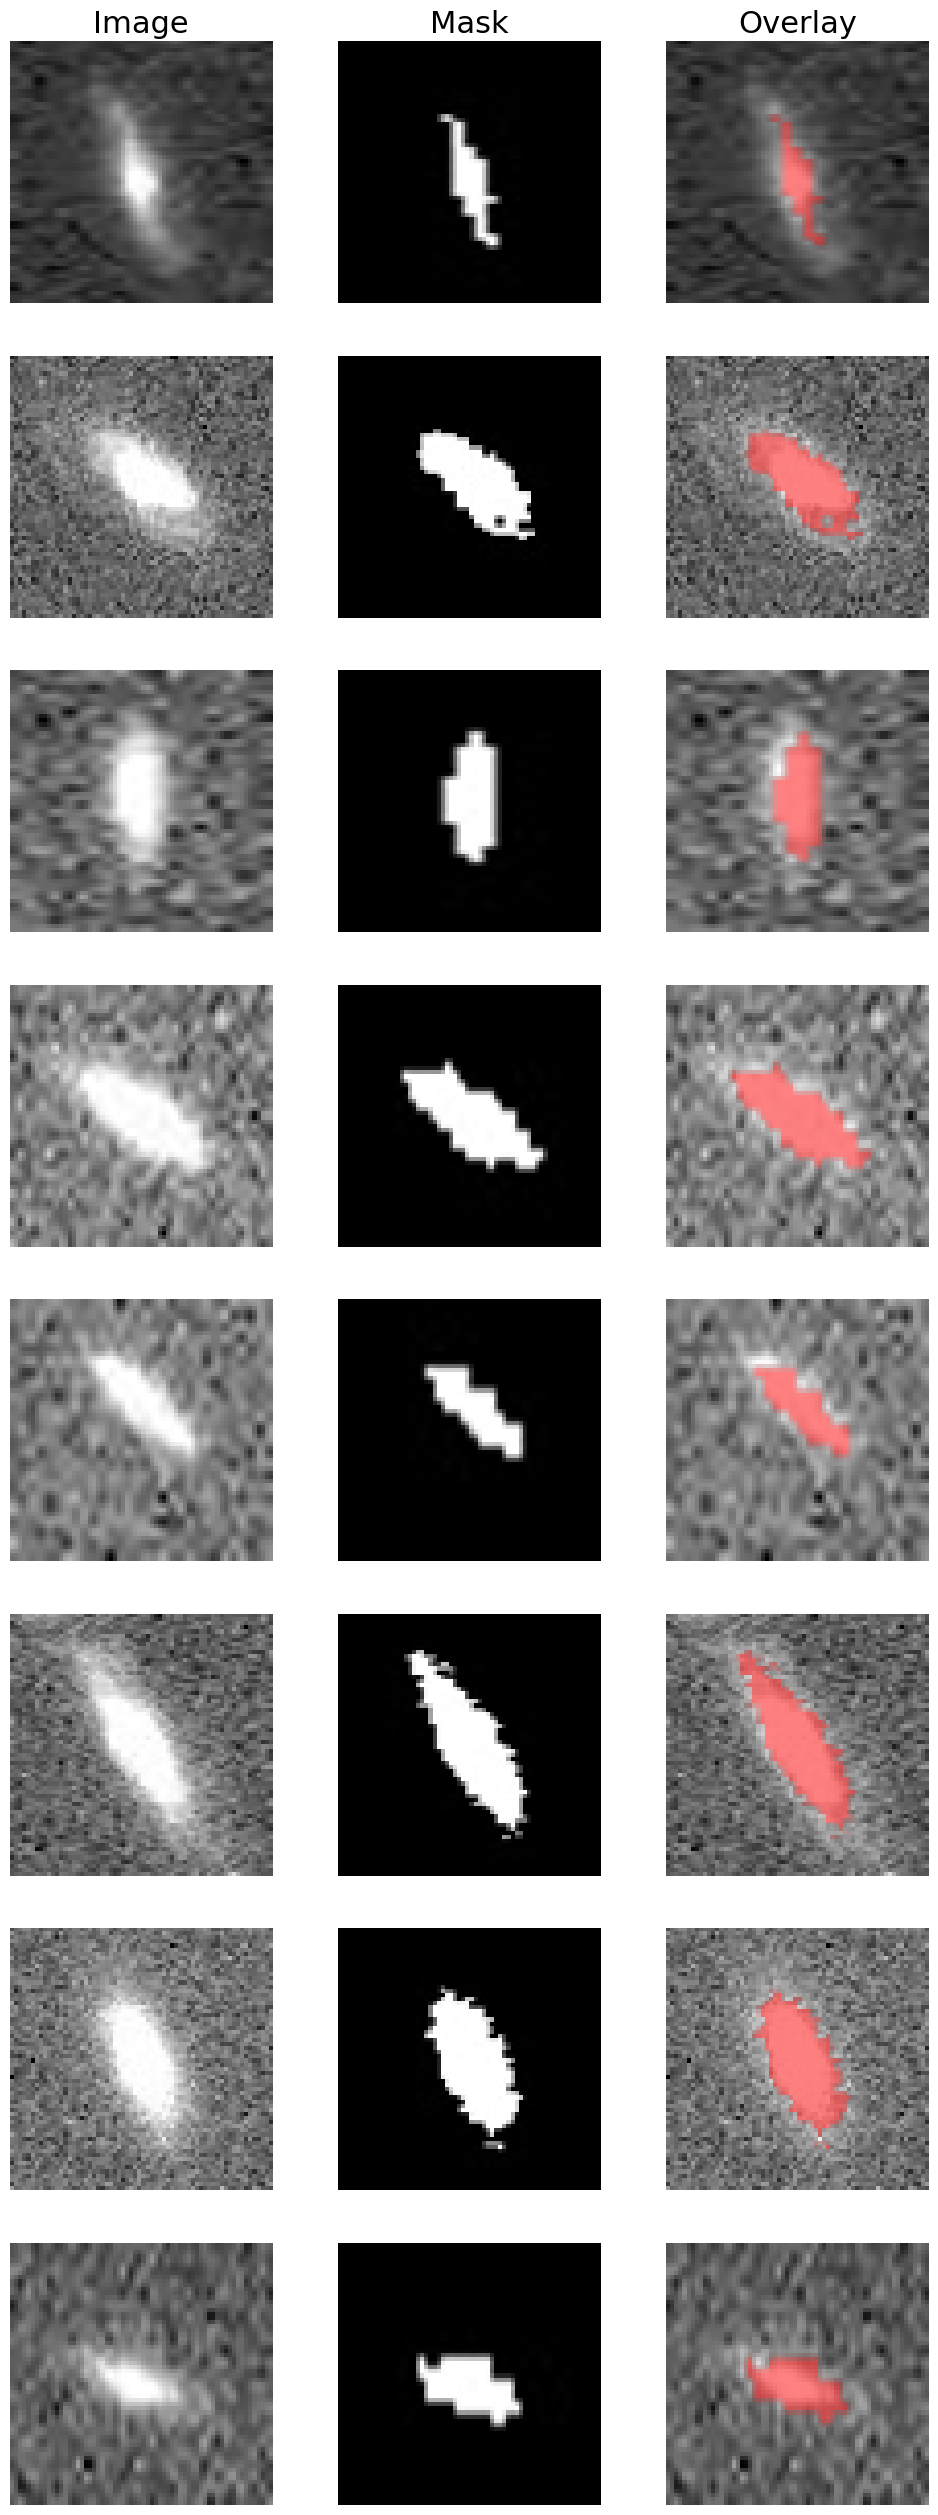

In [16]:
plot_imgs(imgs=x, masks=y, n_imgs=8).show()

In [17]:
# input shape should be (256, 256, 1)
input_shape = x_train[0].shape
print(f"Input shape: {input_shape}\nTrain shape: {x_train.shape}  Val shape: {x_val.shape}")

Input shape: (64, 64, 1)
Train shape: (1091, 64, 64, 1)  Val shape: (273, 64, 64, 1)


## TRAINING SCSS MODEL

In [18]:
# Load model architecture with optimal parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.6)

2024-05-28 20:32:17.195650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

# Set steps parameters acording to size of training set and size of batch
STEPS = x_train.shape[0] // BATCH_SIZE        

# Set Callback that saves only best weights
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor="val_loss",
    save_best_only=True)

In [20]:
model.load_weights("model_galaxie_vsetky_1000_ep.h5") # TRENUJEME ODZNOVA

Epoch 1/1000


2023-05-06 13:15:03.244102: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201



Epoch 1: val_loss improved from inf to 0.45943, saving model to model_galaxie_vsetky_1000_ep_drop_6.h5
54/54 - 11s - loss: 0.3255 - iou: 0.2335 - dice: 0.3764 - val_loss: 0.4594 - val_iou: 0.1507 - val_dice: 0.2616 - 11s/epoch - 212ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 0.45943 to 0.44098, saving model to model_galaxie_vsetky_1000_ep_drop_6.h5
54/54 - 3s - loss: 0.1678 - iou: 0.3241 - dice: 0.4886 - val_loss: 0.4410 - val_iou: 0.1387 - val_dice: 0.2434 - 3s/epoch - 55ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.44098 to 0.21565, saving model to model_galaxie_vsetky_1000_ep_drop_6.h5
54/54 - 3s - loss: 0.1299 - iou: 0.3893 - dice: 0.5599 - val_loss: 0.2156 - val_iou: 0.1240 - val_dice: 0.2205 - 3s/epoch - 58ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 0.21565 to 0.17707, saving model to model_galaxie_vsetky_1000_ep_drop_6.h5
54/54 - 3s - loss: 0.1080 - iou: 0.4434 - dice: 0.6138 - val_loss: 0.1771 - val_iou: 0.2990 - val_dice: 0.4602 - 3s/epoch - 55ms

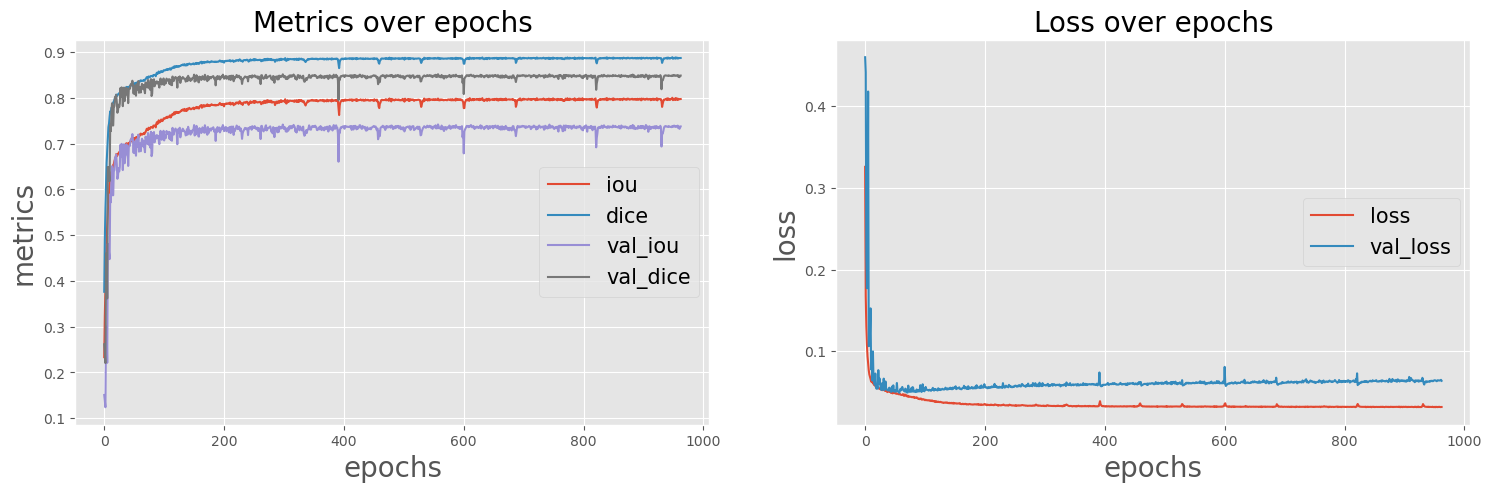

In [16]:
# Train model
#history = model.fit(
#    x_train,
#    y_train,
#    steps_per_epoch=STEPS,
#    epochs=EPOCHS,
#    validation_data=(x_val, y_val),
#    callbacks=[callback_checkpoint],
#    verbose=2)

# # Plot training history (Metrics and Loss)
#plot_metrics(history).show()

cca 22 hodin na macbook pro m1

In [17]:
model.save_weights(model_filename)

In [21]:
 y_pred = model.predict(x_val)

9/9 [==============================] - 2s 188ms/step


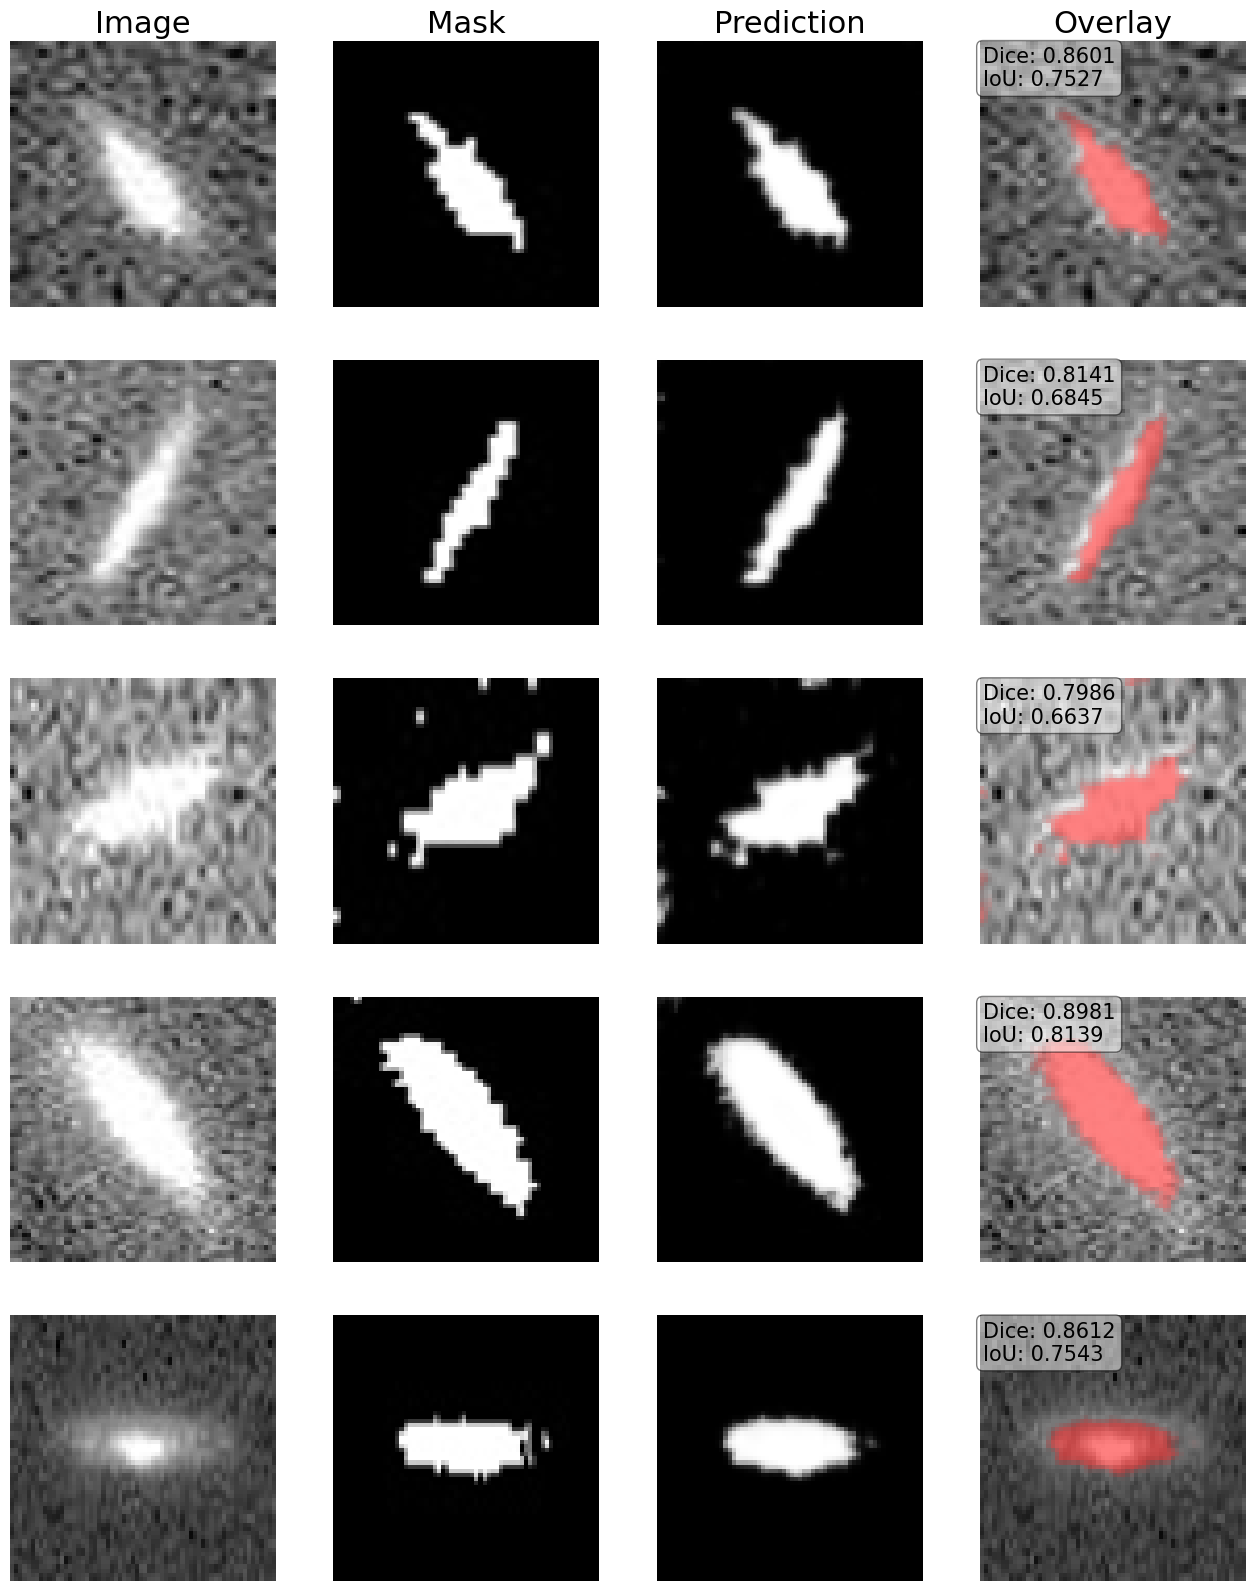

In [22]:
plot_imgs(imgs=x_val, masks=y_val, predictions=y_pred, n_imgs=5).show()

In [23]:
imgs_test = glob.glob("data/testovacia_po_edge_detection/cropped_improved_galaxies/*.jpg")
masks_test = glob.glob("data/testovacia_po_edge_detection/galaxy_improved_masks/*.jpg")

print(f"Imgs number = {len(imgs_test)}\nMasks number = {len(masks_test)}")

# Load data and convert imgs to np.array
imgs_test_list = []
masks_test_list = []
for image, mask in zip(imgs_test, masks_test):
    imgs_test_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_test_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

# Normalization from (0; 255) to (0; 1)
x_test = np.asarray(imgs_test_list, dtype=np.float32)/255
y_test = np.asarray(masks_test_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

Imgs number = 130
Masks number = 130


5/5 [==============================] - 1s 148ms/step


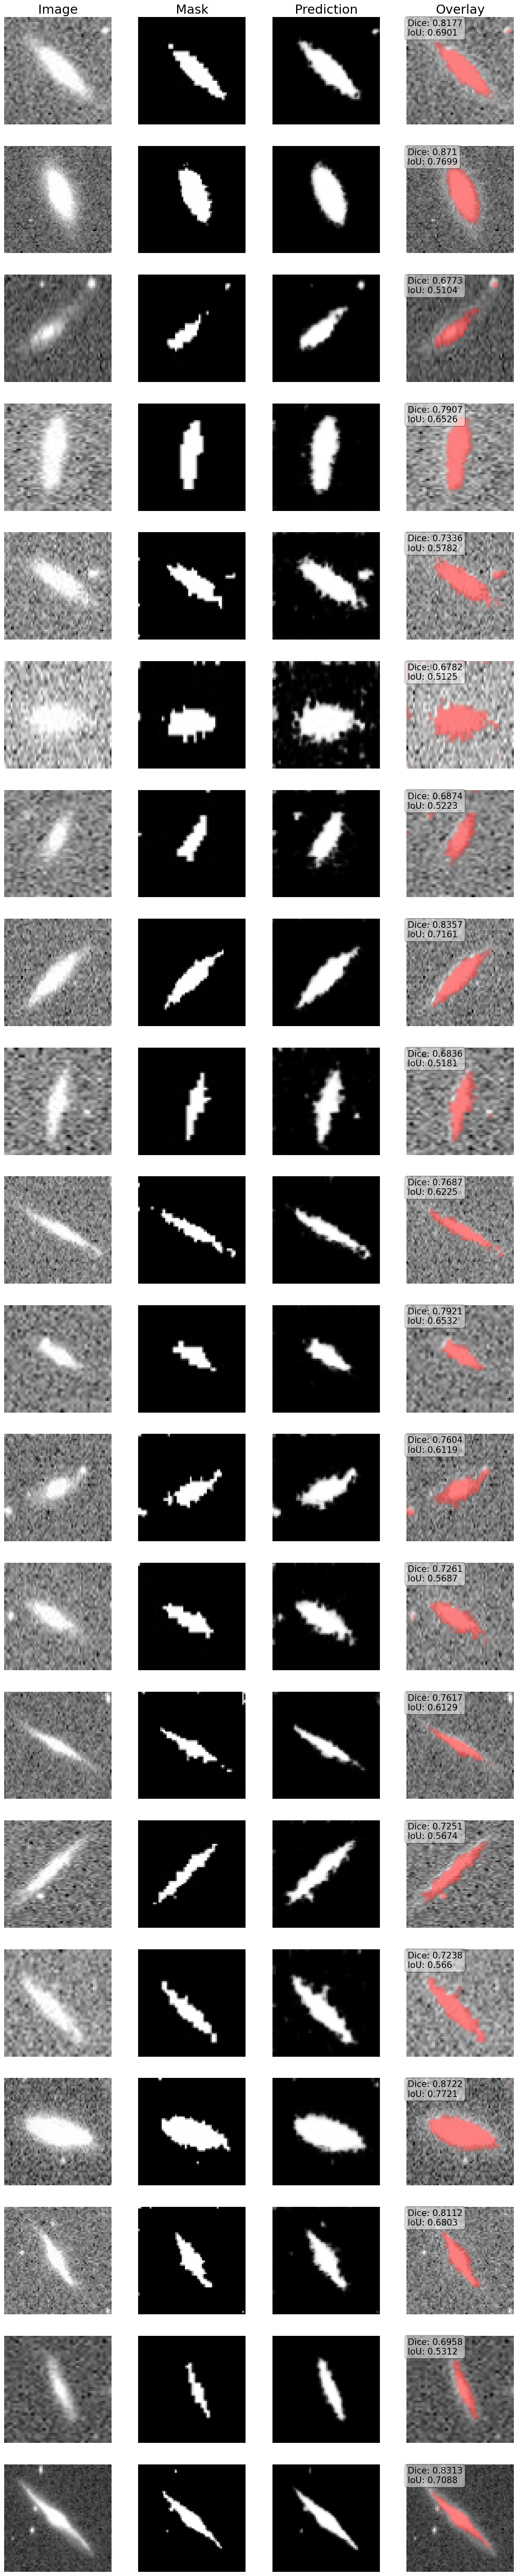

In [24]:
y_pred = model.predict(x_test)  
plot_imgs(imgs=x_test, masks=y_test, predictions=y_pred, n_imgs=20).show()

In [21]:
step = 1
for tresh in range(10, 100 + step, step):
    test_tresh = tresh / 100
    y_pred_bin = np.where(y_pred > test_tresh, 1, 0)  # Set threshold for predicted values

    dice = np.round(dice_np(y_val, y_pred), 4)
    iou_val = np.round(iou_np(y_val, y_pred), 4)

    dice_tresh = np.round(dice_np(y_val, y_pred_bin), 4)
    iou_val_tresh = np.round(iou_np(y_val, y_pred_bin), 4)

    print(f"Validation (> {test_tresh}):\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_val} IoU_tresh: {iou_val_tresh}\n")

ValueError: operands could not be broadcast together with shapes (273,64,64,1) (113,64,64,1) 

4/4 [==============================] - 0s 35ms/step


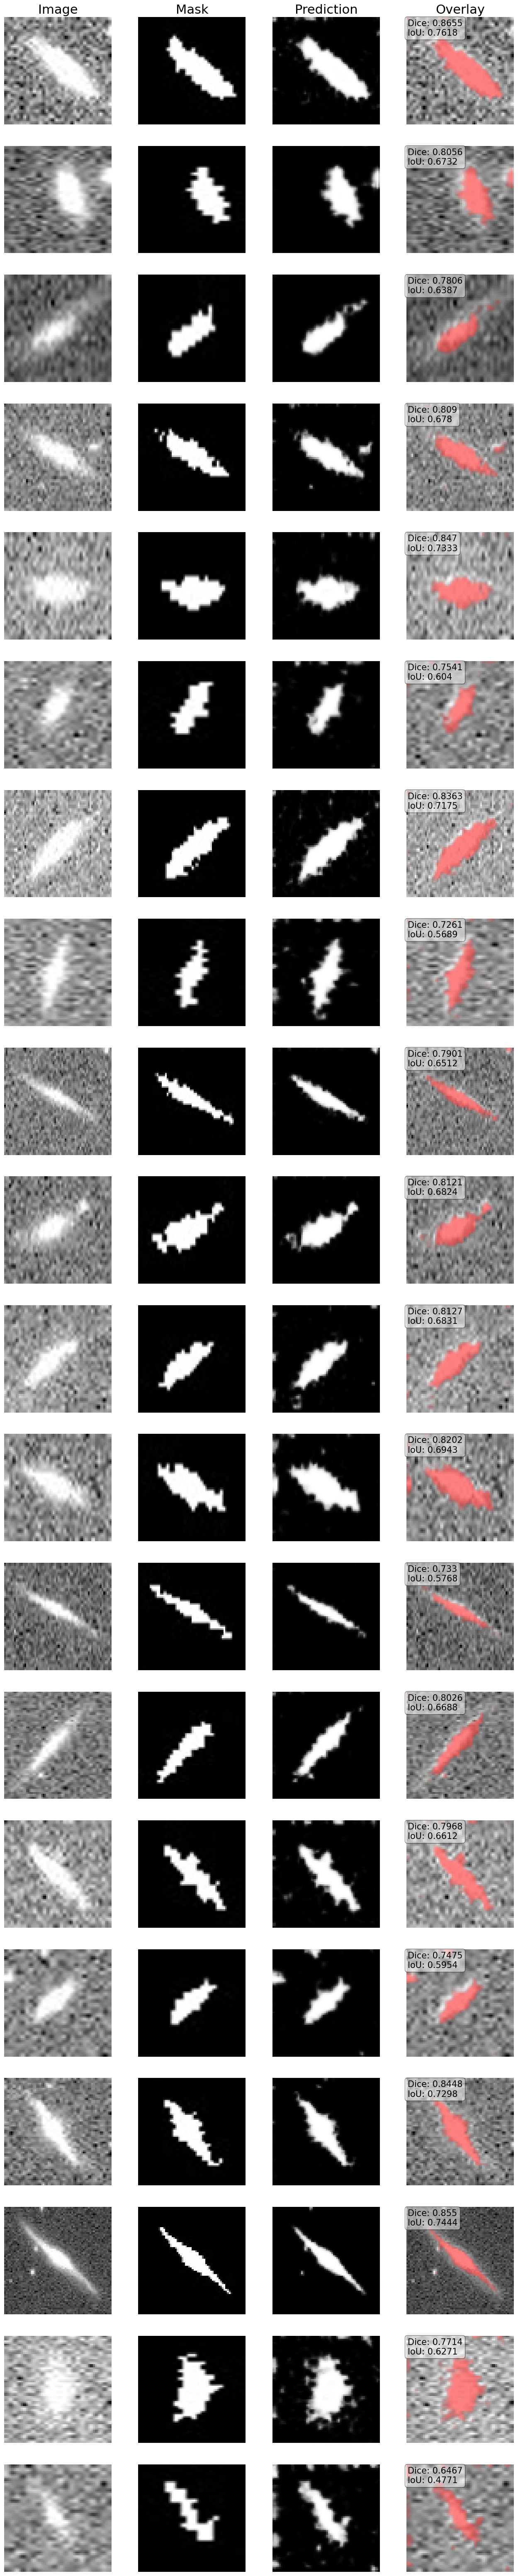

In [22]:
y_pred = model.predict(x_test)  
plot_imgs(imgs=x_test, masks=y_test, predictions=y_pred, n_imgs=20).show()

In [25]:
y_pred_bin = np.where(y_pred > 0.5, 1, 0)  # Set threshold for predicted values

dice = np.round(dice_np(y_val, y_pred), 4)
iou_val = np.round(iou_np(y_val, y_pred), 4)

dice_tresh = np.round(dice_np(y_val, y_pred_bin), 4)
iou_val_tresh = np.round(iou_np(y_val, y_pred_bin), 4)

print(f"Validation:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_val} IoU_tresh: {iou_val_tresh}\n")

ValueError: operands could not be broadcast together with shapes (273,64,64,1) (130,64,64,1) 

In [24]:
step = 1
for tresh in range(10, 100 + step, step):
    test_tresh = tresh / 100
    y_pred_bin = np.where(y_pred > test_tresh, 1, 0)  # Binarize predicted values

    dice = np.round(dice_np(y_test, y_pred), 4)
    iou_test = np.round(iou_np(y_test, y_pred), 4)

    dice_tresh = np.round(dice_np(y_test, y_pred_bin), 4)
    iou_test_tresh = np.round(iou_np(y_test, y_pred_bin), 4)

    print(f"Validation (> {test_tresh}):\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_test} IoU_tresh: {iou_test_tresh}\n")

Validation (> 0.1):
Dice: 0.8075 Dice_tresh: 0.7913
 IoU: 0.6771 IoU_tresh: 0.6547

Validation (> 0.11):
Dice: 0.8075 Dice_tresh: 0.7969
 IoU: 0.6771 IoU_tresh: 0.6624

Validation (> 0.12):
Dice: 0.8075 Dice_tresh: 0.8019
 IoU: 0.6771 IoU_tresh: 0.6693

Validation (> 0.13):
Dice: 0.8075 Dice_tresh: 0.8069
 IoU: 0.6771 IoU_tresh: 0.6763

Validation (> 0.14):
Dice: 0.8075 Dice_tresh: 0.811
 IoU: 0.6771 IoU_tresh: 0.6821

Validation (> 0.15):
Dice: 0.8075 Dice_tresh: 0.8149
 IoU: 0.6771 IoU_tresh: 0.6876

Validation (> 0.16):
Dice: 0.8075 Dice_tresh: 0.8183
 IoU: 0.6771 IoU_tresh: 0.6925

Validation (> 0.17):
Dice: 0.8075 Dice_tresh: 0.8218
 IoU: 0.6771 IoU_tresh: 0.6975

Validation (> 0.18):
Dice: 0.8075 Dice_tresh: 0.8248
 IoU: 0.6771 IoU_tresh: 0.7018

Validation (> 0.19):
Dice: 0.8075 Dice_tresh: 0.8274
 IoU: 0.6771 IoU_tresh: 0.7056

Validation (> 0.2):
Dice: 0.8075 Dice_tresh: 0.83
 IoU: 0.6771 IoU_tresh: 0.7094

Validation (> 0.21):
Dice: 0.8075 Dice_tresh: 0.8324
 IoU: 0.6771 IoU_